In [773]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


def f(x):
    return 3*x**2 - 4*x + 5

In [774]:
f(3.0)

20.0

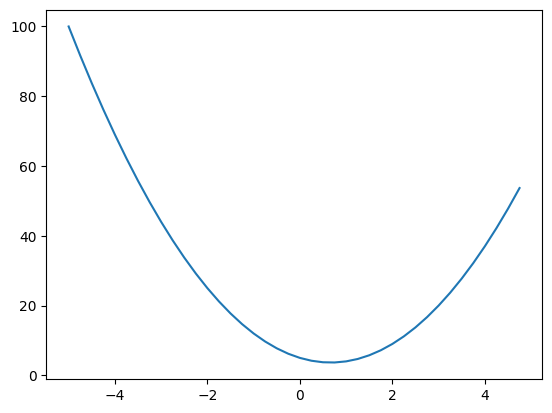

In [775]:
xs = np.arange(-5, 5, 0.25)
plt.plot(xs, f(xs))

In [776]:
h = 0.000001
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [777]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

a2 = a + h
da = a2*b + c

print('d', d)
print('da', da)
print('slope', (da - d) / h)

b2 = b + h
db = a*b2 + c

print('d', d)
print('db', db)
print('slope', (db - d) / h)


c2 = c + h
dc = a*b + c2

print('d', d)
print('dc', db)
print('slope', (dc - d) / h)

d 4.0
da 3.9999969999999996
slope -3.000000000419334
d 4.0
db 4.000002
slope 2.000000000279556
d 4.0
dc 4.000002
slope 0.9999999992515995


In [778]:
class Value():
	def __init__(self, data, _children=(), _op='', label='_'):
		self.data = data
		self.grad = 0
		self._backward = lambda: None
		self._prev = set(_children)
		self._op = _op
		self.label = label
	
	def __repr__(self) -> str:
		return f"Value({self.label if self.label != '' else '_'} data={self.data})"

	def __add__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data + other.data, (self, other), '+')

		def _backward():
			self.grad += 1.0 * out.grad
			other.grad += 1.0 * out.grad
		
		out._backward = _backward
		return out

	def __radd__(self, other): # other + self
		return self + other

	def __sub__(self, other):
		return (self + (-other))

	def __rsub__(self, other):
		return (self + (-other))

	def __neg__(self):
		return self * -1
	
	def __mul__(self, other):
		other = other if isinstance(other, Value) else Value(other)
		out = Value(self.data * other.data, (self, other), '*')

		def _backward():
			self.grad += other.data * out.grad
			other.grad += self.data * out.grad
		out._backward = _backward
		return out

	def __rmul__(self, other):
		return self * other

	def exp(self):
		x = self.data
		out = Value(math.exp(x), (self,), 'exp')

		def _backward():
			self.grad += out.data * out.grad

		out._backward = _backward
		return out

	def __pow__(self, other):
		assert isinstance(other, (int, float)), f"other must be int or float, but {type(other)}"
		out = Value(self.data**other, (self,), f'**{other}')

		def _backward():
			self.grad += other * (self.data**(other-1)) * out.grad

		out._backward = _backward

		return out

	def __truediv__(self, other):
		return self * other**-1
	
	def tanh(self):
		out = Value(math.tanh(self.data), (self,), 'tanh')
		def _backward():
			self.grad += (1 - out.data**2) * out.grad

		out._backward = _backward
		return out

	def backward(self):
		topo = []
		visited = set()
		def build_topo(v):
			if v not in visited:
				visited.add(v)
				for child in v._prev:
					build_topo(child)
				topo.append(v)
		build_topo(self)

		self.grad = 1.0
		for node in reversed(topo):
			node._backward()

In [779]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [780]:
# single neuron backprop using Value class

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights and bias
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
# input x weight + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'
# o = n.tanh(); o.label = 'o'

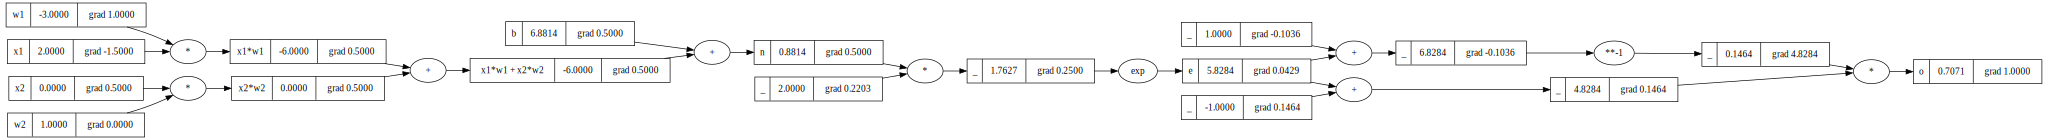

In [781]:
o.backward()
draw_dot(o)

In [782]:
# single neuron backprop using torch

import torch

x1 = torch.tensor([2.0]).double(); 					x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); 					x2.requires_grad=True
w1 = torch.tensor([-3.0]).double(); 				w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); 					w2.requires_grad=True
b = torch.tensor([6.8813735870195432]).double(); 	b.requires_grad=True
n = x1*w1 + x2*w2 + b; 
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-----")
print("x1.grad", x1.grad.item())
print("x2.grad", x2.grad.item())
print("w1.grad", w1.grad.item())
print("w2.grad", w2.grad.item())

0.7071066904050358
-----
x1.grad -1.5000003851533106
x2.grad 0.5000001283844369
w1.grad 1.0000002567688737
w2.grad 0.0


In [783]:
import random 

class Neuron:
	def __init__(self, nin) -> None:
		self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
		self.b = Value(random.uniform(-1, 1))
	
	def __call__(self, x):
		act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
		out = act.tanh()
		return out

	def parameters(self):
		return self.w + [self.b]

class Layer:
	def __init__(self, nin, nout) -> None:
		self.neurons = [Neuron(nin) for _ in range(nout)]
	
	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs) == 1 else outs

	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
	def __init__(self, nin, nouts) -> None:
		sz = [nin] + nouts
		self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]

mlp = MLP(3, [4, 4, 1])

In [784]:
xs = [
	[2.0, 3.0, -1.0],
	[3.0, -1.0, 0.5],
	[0.5, 1.0, 1.0],
	[1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired output


In [785]:
steps = []
losses = []
for i in range(100):
	# forward pass
	ypred = [mlp(x) for x in xs]
	loss = sum([(yout - ygt)**2 for yout, ygt in zip(ys, ypred)])

	# backward pass
	for p in mlp.parameters():
		p.grad = 0.0
	loss.backward()

	# update
	for p in mlp.parameters():
		p.data += -0.05 * p.grad
	
	steps.append(i)
	losses.append(loss.data)

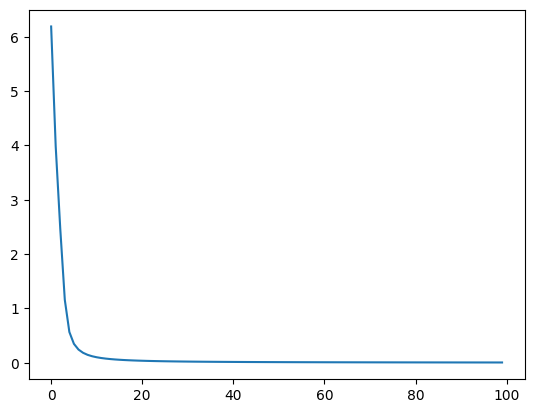

In [786]:
plt.plot(steps, losses)

In [787]:
ypred

[Value(_ data=0.9850805693852259),
 Value(_ data=-0.9535346510883119),
 Value(_ data=-0.9635083475287545),
 Value(_ data=0.9599004516424962)]